In [130]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from evolution.evaluation.evaluator import Evaluator
from experiments.experiment_utils import Experimenter
from generate_url import open_browser, actions_to_url

In [131]:
results_dir = Path("results/presentation/renewablegovernment")
config = json.load(open(results_dir / "config.json"))
gens = len(list(results_dir.glob("[0-9]*.csv")))-1
context = config["context"]
actions = config["actions"]
outcomes = config["outcomes"]
n_elites = config["evolution_params"]["n_elites"]
print(gens, outcomes, len(actions), len(context))

100 {'Average Adjusted cost of energy per GJ': True, 'Emissions Above Paris Agreement': True, 'Average Percent Energy Change': True, 'Government net revenue below zero': False} 115 6


In [132]:
model_params = config["model_params"]
input_specs = pd.read_json("inputSpecs.jsonl", lines=True, precise_float=True)
model_params["in_size"] = len(context) if len(context) > 0 else len(input_specs) - len(actions)
model_params["out_size"] = len(actions)

evaluator = Evaluator("experiments/temp", context, actions, outcomes)
experimenter = Experimenter(results_dir)

make: `enroads' is up to date.


In [133]:
def get_search_space_size(actions: list[str]):
    input_specs = pd.read_json("inputSpecs.jsonl", lines=True, precise_float=True)
    size = 1
    for action in actions:
        row = input_specs[input_specs["varId"] == action].iloc[0]
        if row["kind"] == "switch":
            size *= 2
        elif row["kind"] == "slider":
            combs = int((row["maxValue"] - row["minValue"]) / row["step"])
            size *= combs
    
    size = int(size)
    return size

size = get_search_space_size(actions)
n_atoms = 1e82
print(f"{size:.2e}")
f"{size / n_atoms:.2e}"

1.61e+188


'1.61e+106'

In [134]:
baseline_actions = {}
baseline_df = evaluator.enroads_runner.evaluate_actions(baseline_actions)
outcome_keys = list(outcomes.keys())
custom_outcomes = ["Cost of energy next 10 years", "Average Adjusted cost of energy per GJ", "Average Energy Change", "Average Percent Energy Change", "Year Zero Emissions Reached", "Emissions Above Paris Agreement", "Actions taken", "Government net revenue below zero"]
enroads_outcomes = [key for key in outcome_keys if key not in custom_outcomes]
enroads_outcomes = list(set(enroads_outcomes + ["CO2 Equivalent Net Emissions", "Adjusted cost of energy per GJ", "Government net revenue from adjustments"]))
baseline_metrics = evaluator.outcome_manager.process_outcomes(baseline_actions, baseline_df)
for outcome in outcomes:
    print(f"{outcome}: {baseline_metrics[outcome]}")

print(enroads_outcomes)

Average Adjusted cost of energy per GJ: 20.216877631578946
Emissions Above Paris Agreement: 98.343505
Average Percent Energy Change: 0.010686918717029476
Government net revenue below zero: 0
['CO2 Equivalent Net Emissions', 'Government net revenue from adjustments', 'Adjusted cost of energy per GJ']


In [135]:
final_gen_df = pd.read_csv(results_dir / f"{gens}.csv")
final_pareto = final_gen_df[final_gen_df["rank"] == 1]
final_pareto

,cand_id,parents,rank,distance,Average Adjusted cost of energy per GJ,Emissions Above Paris Agreement,Average Percent Energy Change,Government net revenue below zero
0,83_14,"['80_68', '82_22']",1,inf,71.557737,0.000000,0.037492,-2389.799771
1,88_105,"['22_19', '81_168']",1,inf,18.777030,112.383775,0.011477,-42.035765
2,95_120,"['22_19', '88_105']",1,inf,18.763707,111.960385,0.011337,-44.340856
3,97_92,"['89_58', '89_58']",1,inf,23.551564,64.280675,0.025114,0.000000
4,98_160,"['84_118', '84_118']",1,inf,19.860673,99.120215,0.010714,0.000000
...,...,...,...,...,...,...,...,...
134,100_104,"['95_120', '99_149']",1,0.016767,18.921128,111.690515,0.011503,-36.859991
135,100_135,"['99_107', '99_120']",1,0.015504,22.176859,71.035585,0.021753,-60.650834
136,100_38,"['99_173', '99_90']",1,0.013727,26.543115,62.716115,0.019505,-4.650032
137,99_120,"['97_92', '84_118']",1,0.010425,20.679868,78.208415,0.016703,-94.063303


In [136]:
if len(final_pareto) < 10:
    sample_points = final_pareto["cand_id"].tolist()
else:
    sample_points = final_pareto.sort_values("distance", ascending=False)["cand_id"].head(9).tolist()

sample_points

['83_14',
 '88_105',
 '95_120',
 '97_92',
 '98_160',
 '99_93',
 '100_48',
 '100_159',
 '99_0']

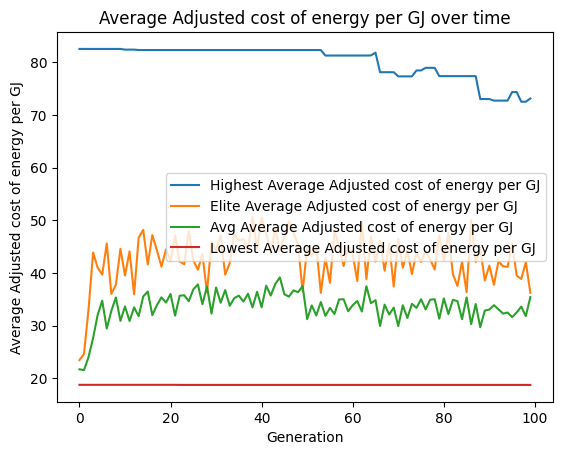

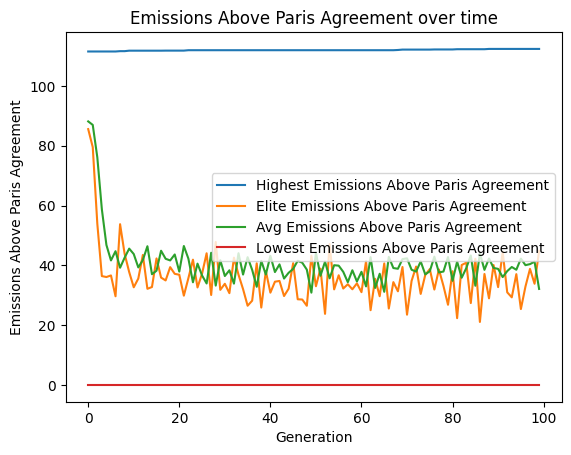

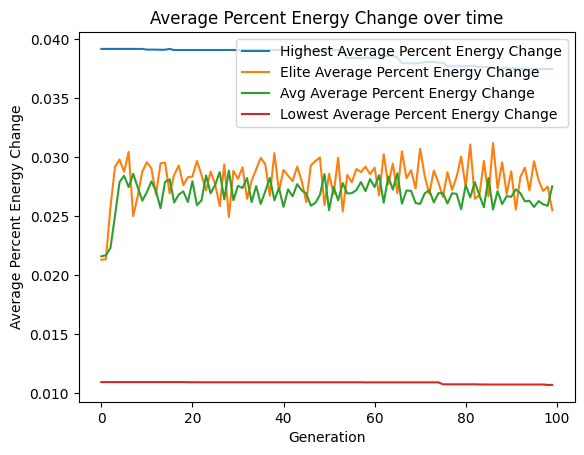

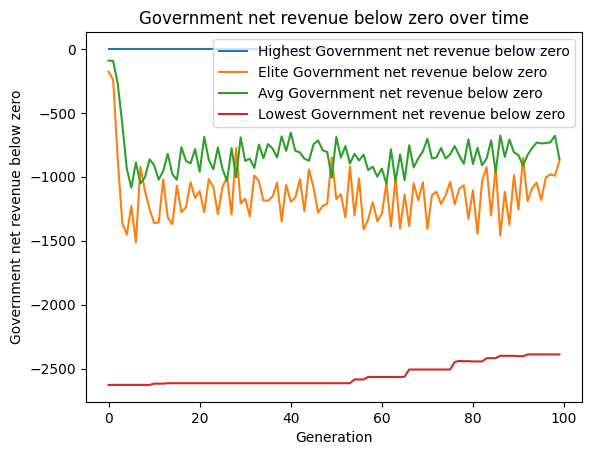

In [137]:
def plot_objective_over_time(outcome):
    best = []
    worst = []
    avg = []
    elite = []
    for gen in range(gens):
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        pareto = gen_df[gen_df["rank"] == 1]
        scores = pareto.sort_values("distance", ascending=False)[outcome]
        best.append(scores.max())
        worst.append(scores.min())
        avg.append(scores.mean())
        elite.append(scores.iloc[:n_elites].mean())
    
    # plt.plot(range(gens), [baseline_df[outcome].iloc[-1] for _ in range(gens)], label=f"Baseline {outcome}", color="black")

    plt.plot(range(gens), best, label=f"Highest {outcome}")
    plt.plot(range(gens), elite, label=f"Elite {outcome}")
    plt.plot(range(gens), avg, label=f"Avg {outcome}")
    plt.plot(range(gens), worst, label=f"Lowest {outcome}")
    plt.legend()
    plt.xlabel("Generation")
    plt.ylabel(outcome)
    plt.title(f"{outcome} over time")
    plt.show()

for outcome in outcomes:
    plot_objective_over_time(outcome)

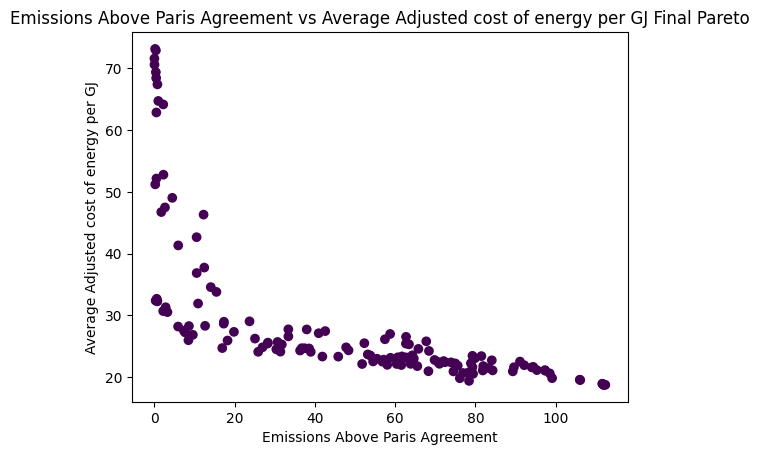

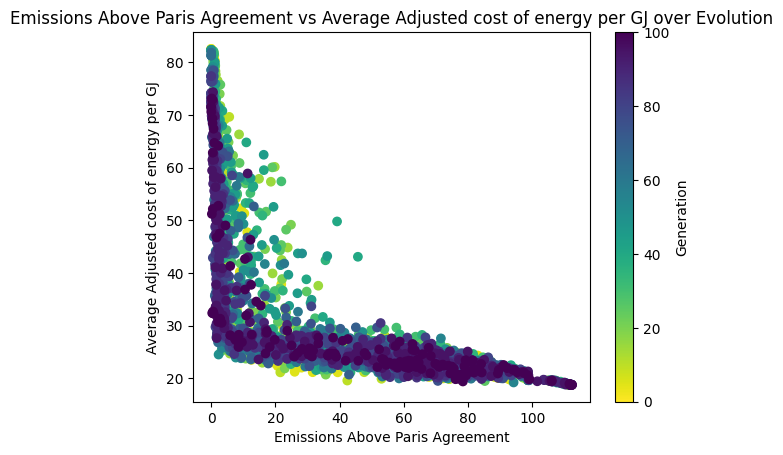

In [138]:
def plot_two_objective(outcome1, outcome2, gens, pareto=True):

    gen_dfs = []
    for gen in gens:
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        gen_df = gen_df[gen_df["rank"] == 1] if pareto else gen_df
        gen_df["color"] = gen
        gen_dfs.append(gen_df)
    
    total_gen_df = pd.concat(gen_dfs)
    cmap = "viridis_r" if len(gens) != 1 else "viridis"
    plt.scatter(total_gen_df[outcome1], total_gen_df[outcome2], c=total_gen_df["color"], cmap=cmap)

    title = f"{outcome1} vs {outcome2} Final Pareto"
    if len(gens) != 1:
        plt.colorbar(label="Generation")
        title = f"{outcome1} vs {outcome2} over Evolution"
    plt.title(title)
    plt.ylabel(outcome2)
    plt.xlabel(outcome1)
    plt.show()

plot_two_objective(outcome_keys[1], outcome_keys[0], [gens])
plot_two_objective(outcome_keys[1], outcome_keys[0], range(0, gens+1, 5))

In [139]:
best_cand_ids = []
for outcome, ascending in outcomes.items():
    best_cand_ids.append(final_pareto.sort_values(outcome, ascending=ascending).iloc[0]["cand_id"])
    print(final_pareto.sort_values(outcome, ascending=ascending).iloc[0][outcome_keys])
    print()
best_cand_ids = list(set(best_cand_ids))
best_cand_ids

Average Adjusted cost of energy per GJ     18.763707
Emissions Above Paris Agreement           111.960385
Average Percent Energy Change               0.011337
Government net revenue below zero         -44.340856
Name: 2, dtype: object

Average Adjusted cost of energy per GJ      71.557737
Emissions Above Paris Agreement                   0.0
Average Percent Energy Change                0.037492
Government net revenue below zero        -2389.799771
Name: 0, dtype: object

Average Adjusted cost of energy per GJ    19.860673
Emissions Above Paris Agreement           99.120215
Average Percent Energy Change              0.010714
Government net revenue below zero               0.0
Name: 4, dtype: object

Average Adjusted cost of energy per GJ     21.11609
Emissions Above Paris Agreement           84.295295
Average Percent Energy Change              0.013618
Government net revenue below zero               0.0
Name: 25, dtype: object



['83_14', '100_6', '95_120', '98_160']

In [140]:
context_input, context_vals = evaluator.context_dataset[0]

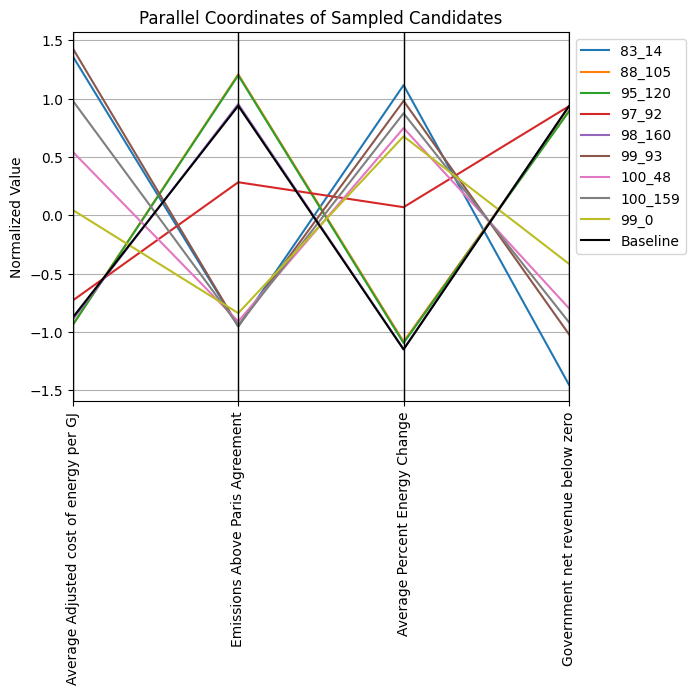

In [141]:
def plot_parallel_coordinates(cand_ids):
    coords_dicts = []
    for cand_id in cand_ids:
        gen = int(cand_id.split("_")[0])
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        row = gen_df[gen_df["cand_id"] == cand_id].iloc[0]
        cand_coords = [row[outcome] for outcome in outcomes]
        cand_dict = dict(zip(outcomes.keys(), cand_coords))
        cand_dict["cand_id"] = cand_id
        coords_dicts.append(cand_dict)

    baseline_dict = {outcome: metric for outcome, metric in baseline_metrics.items()}
    baseline_dict["cand_id"] = "Baseline"
    coords_dicts.append(baseline_dict)

    coords_df = pd.DataFrame(coords_dicts)
    normalized_df = coords_df[outcomes.keys()]
    normalized_df = (normalized_df - normalized_df.mean()) / (normalized_df.std() + 1e-10)
    normalized_df["cand_id"] = coords_df["cand_id"]
    
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    # Color baseline black
    colors[len(coords_df)-1] = "black" 
    pd.plotting.parallel_coordinates(normalized_df, "cand_id", color=colors)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xticks(rotation=90)
    plt.ylabel("Normalized Value")
    plt.title("Parallel Coordinates of Sampled Candidates")

plot_parallel_coordinates(sample_points)

In [142]:
def get_average_df(dfs: list[pd.DataFrame]):
    avg_df = dfs[0].copy()
    for df in dfs[1:]:
        avg_df += df
    avg_df /= len(dfs)
    return avg_df

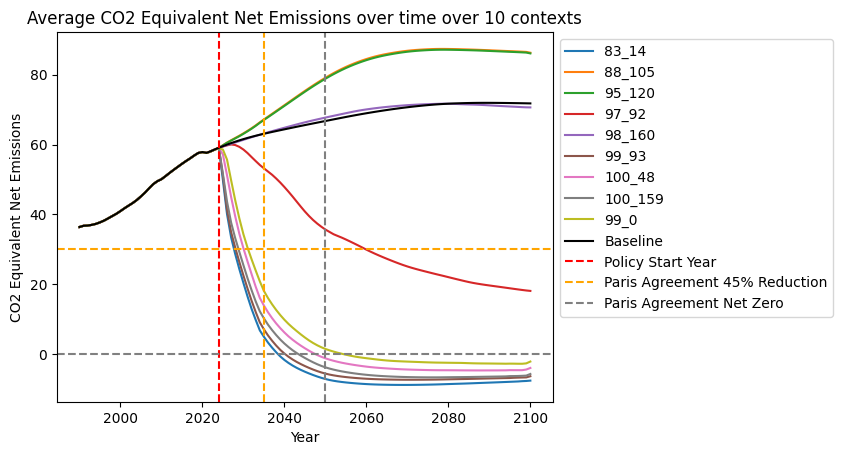

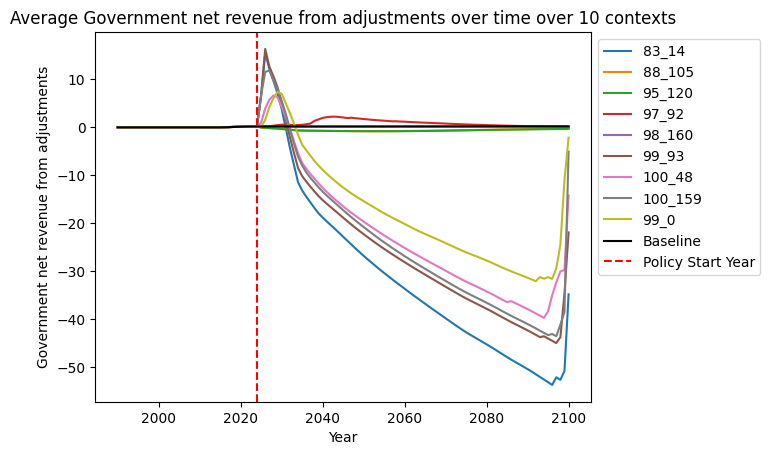

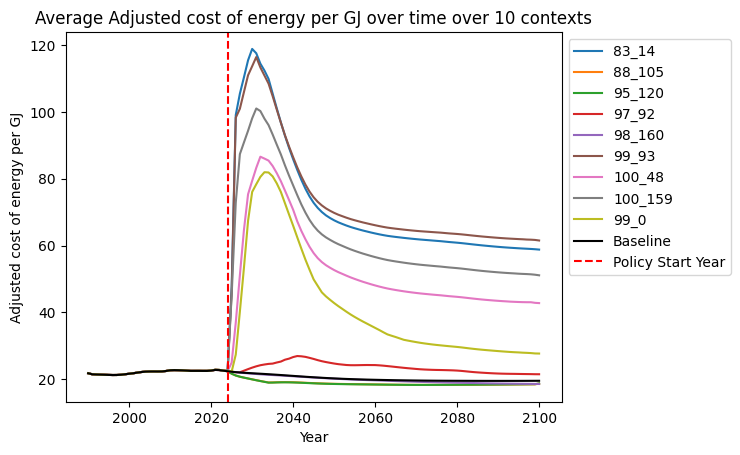

In [143]:
def plot_outcome_over_time(outcome, cand_ids, paris=False):
    for cand_id in cand_ids:
        cand = experimenter.get_candidate_from_id(cand_id)
        cand_outcomes = evaluator.evaluate_candidate(cand)
        avg_df = get_average_df(cand_outcomes)
        plt.plot(range(1990, 2101), avg_df[outcome], label=f"{cand_id}")
    plt.plot(range(1990, 2101), baseline_df[outcome], color="black", label="Baseline")
    plt.axvline(x=2024, color="red", linestyle="--", label="Policy Start Year")
    if outcome == "CO2 Equivalent Net Emissions":
        plt.axhline(y=0, color="gray", linestyle="--")
        if paris:
            plt.axhline(y=54.4789*0.55, color="orange", linestyle="--", label="Paris Agreement 45% Reduction")
            plt.axvline(x=2035, color="orange", linestyle="--")
            plt.axvline(x=2050, color="gray", linestyle="--", label="Paris Agreement Net Zero")
    plt.legend(bbox_to_anchor=(1, 1))
    if len(cand_outcomes) > 1:
        plt.title(f"Average {outcome} over time over {len(cand_outcomes)} contexts")
    else:
        plt.title(f"{outcome} over time")
    plt.xlabel("Year")
    plt.ylabel(outcome)
    plt.show()

paris = "Emissions Above Paris Agreement" in outcomes
for outcome in enroads_outcomes:
    plot_outcome_over_time(outcome, sample_points, paris)

In [144]:
def plot_energy_usage(cand_ids):
    fig, axes = plt.subplots(1, len(cand_ids), sharey=True, figsize=(7.5 * len(cand_ids), 5))
    if len(cand_ids) == 1:
        axes = [axes]
    axes[0].set_ylabel("Energy (Exajoules / year)")
    for cand_id, ax in zip(cand_ids, axes):
        cand_outcomes = None
        if cand_id == "baseline":
            cand_outcomes = baseline_df
        else:
            cand = experimenter.get_candidate_from_id(cand_id)
            outcomes = evaluator.evaluate_candidate(cand)
            cand_outcomes = get_average_df(outcomes)
        colors = ["brown", "red", "blue", "green", "pink", "lightblue", "orange"]
        energies = ["coal", "oil", "gas", "renew and hydro", "bio", "nuclear", "new tech"]
        demands = [f"Primary energy demand of {energy}" for energy in energies]
        energy_df = cand_outcomes[demands]
        for i, demand in enumerate(demands):
            base = 0
            if i != 0:
                for j in range(i):
                    base += energy_df[demands[j]]
            if energy_df[demand].sum() == 0:
                continue
            ax.fill_between(range(1990, 2101), base, base + energy_df[demand], label=energies[i], color=colors[i], alpha=0.8)
        if cand_id != "baseline" and len(outcomes) > 1:
            ax.set_title(f"Average Energy Usage for Candidate {cand_id}")
        else:
            ax.set_title(f"Energy Usage for {cand_id}")
        ax.set_xlabel("Year")
        ax.axvline(x=2024, color="red", linestyle="--")

    plt.suptitle("Global Sources of Primary Energy")
    # Reverse the legend order
    plt.legend(reversed(ax.get_legend_handles_labels()[0]), reversed(ax.get_legend_handles_labels()[1]))
    plt.show()

In [145]:
def plot_energy_difference(cand_id):
    colors = ["brown", "red", "blue", "green", "pink", "lightblue", "orange"]
    energies = ["coal", "oil", "gas", "renew and hydro", "bio", "nuclear", "new tech"]
    demands = [f"Primary energy demand of {energy}" for energy in energies]

    cand = experimenter.get_candidate_from_id(cand_id)
    cand_outcomes = evaluator.evaluate_candidate(cand)
    avg_outcomes = get_average_df(cand_outcomes)
    energy_df = avg_outcomes[demands]

    energy_baseline = baseline_df[demands]

    diff_df = energy_df - energy_baseline
    plt.grid(axis="y")
    plt.bar(energies, diff_df.iloc[-1], color=colors)
    plt.ylabel("Difference in Energy (Exajoules / year)")
    plt.xlabel("Energy Source")
    if len(cand_outcomes) > 1:
        plt.title(f"Average Difference in Energy from Baseline for {cand_id} in 2100 over {len(cand_outcomes)} contexts")
    else:
        plt.title(f"Difference in Energy from Baseline for {cand_id} in 2100")
    plt.xticks(rotation=90)
    plt.show()

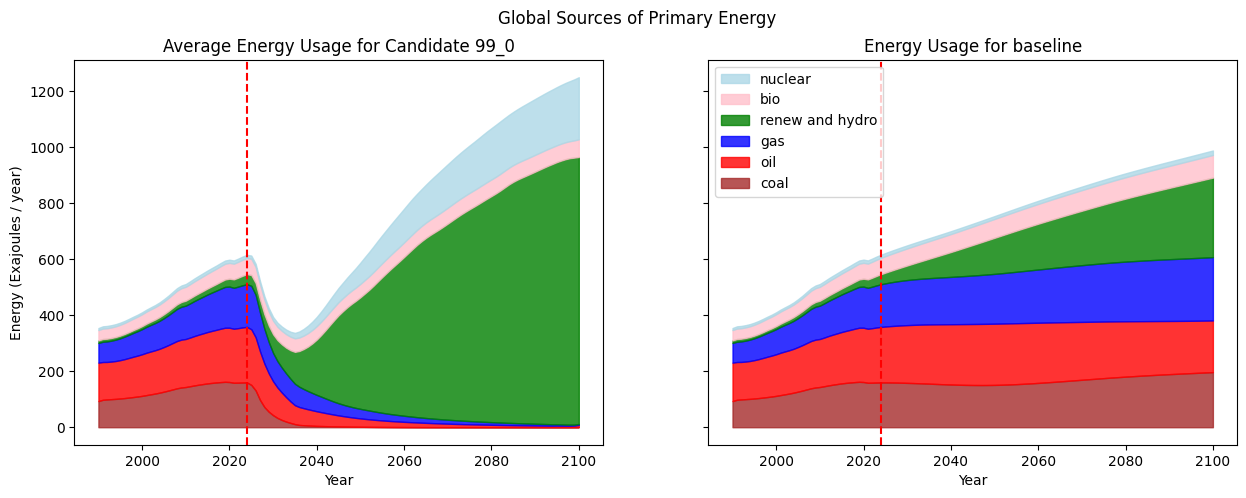

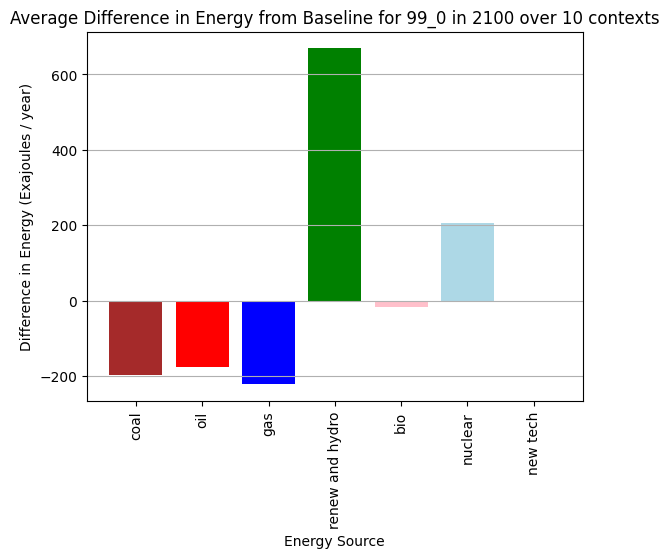

In [152]:
examples = ["99_0"]
plot_energy_usage(examples +  ["baseline"])
plot_energy_difference(examples[0])

In [153]:
for example in examples:
    open_browser(results_dir, example, 0)
    open_browser(results_dir, example, 9)

make: `enroads' is up to date.
make: `enroads' is up to date.


In [148]:
print(len(actions))

115


In [149]:
from matplotlib.colors import ListedColormap
def get_actions_used(cand_ids):
    x_axis = []
    grid = []
    for cand_id in cand_ids:
        actions_used = np.zeros(len(actions))
        cand = experimenter.get_candidate_from_id(cand_id)
        cand_actions = experimenter.get_candidate_actions(cand, context_input, context_vals)
        for action, val in cand_actions.items():
            row = input_specs[input_specs["varId"] == action].iloc[0]
            if row["defaultValue"] != val:
                if action not in x_axis:
                    x_axis.append(action)
                if row["kind"] == "slider":
                    normalized_val = (val - row["minValue"]) / (row["maxValue"] - row["minValue"])
                else:
                    normalized_val = 1 if val == row["onValue"] else 0
                actions_used[x_axis.index(action)] = normalized_val
        grid.append(actions_used)
    
    # Switch x axis labels to their nicer names
    for i, action in enumerate(x_axis):
        x_axis[i] = input_specs[input_specs["varId"] == action]["varName"].iloc[0]

    grid = np.stack(grid).T[:len(x_axis)]
    grid = np.flip(grid, axis=0)
    plt.figure(figsize=(5, 10))
    plt.yticks(range(len(x_axis)), reversed(x_axis))
    plt.xticks(range(len(cand_ids)), cand_ids, rotation=90)
    plt.title("Number of Actions Used vs. Action Labels")
    plt.imshow(grid, cmap="viridis")

if "Actions taken" in outcomes:
    cand_ids_by_actions = final_pareto.sort_values("Actions taken", ascending=True)["cand_id"].tolist()
    get_actions_used(cand_ids_by_actions)

In [150]:
if "Actions taken" in outcomes:
    from experiments.heuristic import Heuristic
    heuristic = Heuristic(actions)
    actions_order, heuristic_dict = heuristic.find_heuristic()
    heuristic.plot_actions_used(actions_order, heuristic_dict)

In [151]:
if "Actions taken" in outcomes:
    temp_actions_dict = {}
    carbons = []
    for i, action in enumerate(actions_order):
        temp_actions_dict[action] = heuristic_dict[action]
        outcome_df = evaluator.enroads_runner.evaluate_actions(temp_actions_dict)
        carbon = outcome_df["CO2 Equivalent Net Emissions"].iloc[-1]
        carbons.append(carbon)

    plt.xlabel("Actions Taken")
    plt.ylabel("CO2 Equivalent Net Emissions")
    plt.scatter(final_pareto["Actions taken"], final_pareto["CO2 Equivalent Net Emissions"], label="Trained Pareto")
    plt.scatter(range(1, len(actions_order)+1), carbons, label="Greedy Heuristic")
    plt.scatter([0], baseline_metrics["CO2 Equivalent Net Emissions"], label="Baseline", color="black")
    plt.axhline(y=0, color="gray", linestyle="--")
    plt.title("Pareto Front vs. Greedy Heuristic")
    plt.legend()
    plt.show()